# RDS Homework 3 Template, Spring 2022


# Setup

In [1]:
!pip install shap

     |████████████████████████████████| 564 kB 5.0 MB/s 


In [1]:
from __future__ import print_function

import shap
import pandas as pd
import sklearn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.ensemble
import sklearn.metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import tqdm
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import fetch_20newsgroups
from collections import defaultdict
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

# Configs
np.random.seed(1)
shap.initjs()
sns.set_style("whitegrid")

plot_shap=True # NOTE: Turn False to disable shap plots as they can be slow to load 

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/luohaochen/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Problem 3

### Part (A)

In [2]:
# Mark the categories of interest
categories = ['alt.atheism', 'soc.religion.christian']

# Fetch the data
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)

# Set outcome class names
class_names = ['atheism', 'christian']


In [3]:
# Initialize & fit tf-idf vectorizer (see notebook for lab 10)
vectorizer = TfidfVectorizer(min_df=1)
news_train = vectorizer.fit_transform(newsgroups_train.data)
news_test = vectorizer.transform(newsgroups_test.data)

In [4]:
# Train & fit the classifier 
sgd = SGDClassifier(loss='log')
sgd.fit(news_train,newsgroups_train.target)

SGDClassifier(loss='log')

### Part (B)

Generate a confusion matrix (hint: use [sklearn.metrics.confusion_matrix](https://https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html))
to evaluate the accuracy of the classifier. The confusion matrix should contain a count of correct Christian, correct Atheist, incorrect Christian, and incorrect Atheist predictions.

In [44]:
# Generate predictions from your SGDClassifier
result = sgd.predict(news_test)

In [45]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(newsgroups_test.target, result)

array([[276,  43],
       [  4, 394]])

#### Explainer

In [46]:
# Initialize the explainer and apply to test data
explainer = shap.LinearExplainer(sgd, news_train,feature_perturbation="interventional")

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


In [51]:
# Select 5 documents in the test set for explanation
print(newsgroups_train.target[:10])
print(result[:10])
shap_values = explainer.shap_values(news_test)
test_list = list(range(0,5))
test_list

[1 0 1 0 1 1 1 1 0 1]
[1 1 0 1 0 1 1 1 1 0]


[0, 1, 2, 3, 4]

In [11]:
# Visually explain 5 documents selected from the test set
shap.initjs()
shap_values = explainer.shap_values(news_test)
for idx in test_list:
    shap.force_plot(explainer.expected_value, shap_values[idx][:], news_test.toarray()[idx][:],feature_names=vectorizer.get_feature_names())

### Part (C)


#### Part (i)

In [12]:
# Compute the accuracy of the classifier and the number of misclassified documents
from sklearn import metrics
accuracy = metrics.accuracy_score(newsgroups_test.target,result)
print("Accuracy:",accuracy)
mis_num=0
idx=0
mis_index=[]
for tar, res in zip(newsgroups_test.target, result):
    if tar!=res:
        mis_num+=1
        mis_index.append(idx)
    idx+=1
print("Number of misclassified documents:",mis_num)

Accuracy: 0.9344490934449093
Number of misclassified documents: 47


#### Part (ii)

In [13]:
# function to calculate confidence
# (note: this function assumes your TF-IDF vectorized test data is called X_test)
X_test = news_test
def get_conf(doc_id):
  '''doc_id: the index of the misclassified documents'''
  conf = []
  for idx in doc_id:
      prob = sgd.predict_proba(X_test[idx])[0]
      conf.append(abs(prob[0]-prob[1]))
  return conf

# Calculate conf_i for all misclassified documents
conf_list = get_conf(mis_index)


(array([ 7., 14.,  5.,  9.,  6.,  1.,  3.,  2.]),
 array([7.56631506e-04, 1.14680182e-01, 2.28603732e-01, 3.42527282e-01,
        4.56450832e-01, 5.70374383e-01, 6.84297933e-01, 7.98221483e-01,
        9.12145033e-01]),
 <BarContainer object of 8 artists>)

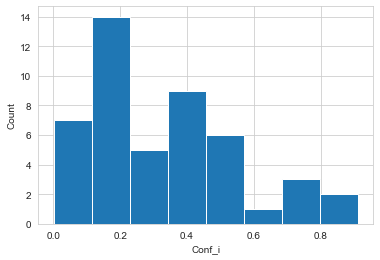

In [14]:
# Plot conf_i
import matplotlib.pyplot as plt
plt.xlabel("Conf_i")
plt.ylabel("Count")
plt.hist(conf_list,bins=8)

#### Part (iii)

Identify all words that contributed to the misclassification of documents. Hint: See the "Prediction decomposition" section of lab 10 notebook.

In [15]:
# Identify words (word_j) that contributed to the misclassification of documents
# Identify words (word_j) that contributed to the misclassification of documents
mis_words = []
import operator
for idx in mis_index:
    vals = shap_values[idx,:]
    positive_sentiment_weight = defaultdict(float)
    negative_sentiment_weight = defaultdict(float)
    feats = vectorizer.get_feature_names()
    for feat_i, val_i in zip(feats, vals):
        if val_i > 0:
            positive_sentiment_weight[feat_i] += val_i
        elif val_i < 0:
            negative_sentiment_weight[feat_i] += val_i

    if result[idx] == 0:
        mis_words.append(list(sorted(negative_sentiment_weight.items(), key=operator.itemgetter(1), reverse=True)))
    elif result[idx] == 1:
        mis_words.append(list(sorted(positive_sentiment_weight.items(), key=operator.itemgetter(1), reverse=True)))

6296


(array([2559.,  793.,  102.,   46.,   25.,   19.,   17.,   23.,   45.,
          60.,  239., 2368.]),
 array([ 1.        ,  4.58333333,  8.16666667, 11.75      , 15.33333333,
        18.91666667, 22.5       , 26.08333333, 29.66666667, 33.25      ,
        36.83333333, 40.41666667, 44.        ]),
 <BarContainer object of 12 artists>)

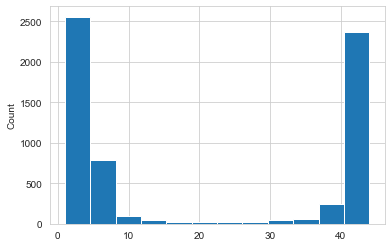

In [16]:
# Compute the number of documents (count_j) these words helped to misclassify
from collections import Counter
words = []
words_weight = []
for l in mis_words:
    for pair in l:
        words.append(pair[0])
        words_weight.append({pair[0]:pair[1]})
result = Counter(words)
words_list = []
for element in words:
    if(element not in words_list):
        words_list.append(element)
print(len(words_list))
count_word = []
for res in result.items():
    count_word.append(res[1])
plt.ylabel('Count')
plt.hist(count_word,bins=12)

In [17]:
# Compute the sum of absolute SHAP values (weight_j) for each word_j
z = Counter()
for value in words_weight:
     z+=Counter(value)
print(z)

Counter({'keith': 3.2768988331008737, 'of': 2.3007458370363647, 'the': 2.2670957294474223, 'christian': 2.1488457988109038, 'church': 1.892630794544217, 'faith': 1.8177410561204175, 'it': 1.790967422865447, 'islam': 1.7752040833287275, 'christ': 1.7312057996774541, 'jesus': 1.6460490829231536, 'to': 1.4520005644238219, 'umd': 1.4223868685716121, 'and': 1.3889981672423497, 'islamic': 1.3713624381820975, 'edu': 1.3556145899776435, 'com': 1.2952587904419823, 'caltech': 1.2839586088204162, 'is': 1.230811618632768, 'temple': 1.2181699401330106, 'you': 1.2095177224605227, 'host': 1.1035080162316537, 'nntp': 1.0972686233677014, 'atheism': 1.0855260675537637, 'mathew': 1.0703713405126398, 'atheists': 1.01727648625324, 'love': 1.0163497452089718, 'posting': 1.014940856526925, 'mangoe': 1.007585374782337, 'writes': 0.9878112501201235, 'me': 0.9020025609157396, 'we': 0.8968501201669702, 'god': 0.8938732220589279, 'as': 0.8584643471802734, 'christians': 0.8386835430700815, 'an': 0.7949181463921549

(array([2.267e+03, 6.130e+02, 3.070e+02, 2.030e+02, 1.310e+02, 1.070e+02,
        7.700e+01, 8.500e+01, 6.300e+01, 4.900e+01, 5.400e+01, 4.900e+01,
        3.900e+01, 2.000e+01, 2.500e+01, 1.800e+01, 1.800e+01, 2.600e+01,
        1.800e+01, 1.300e+01, 1.300e+01, 1.700e+01, 1.200e+01, 1.200e+01,
        7.000e+00, 9.000e+00, 9.000e+00, 1.100e+01, 4.000e+00, 9.000e+00,
        9.000e+00, 5.000e+00, 6.000e+00, 7.000e+00, 5.000e+00, 7.000e+00,
        4.000e+00, 2.000e+00, 2.000e+00, 4.000e+00, 4.000e+00, 4.000e+00,
        3.000e+00, 1.000e+00, 3.000e+00, 3.000e+00, 4.000e+00, 3.000e+00,
        2.000e+00, 5.000e+00, 5.000e+00, 1.000e+00, 0.000e+00, 3.000e+00,
        1.000e+00, 1.000e+00, 5.000e+00, 2.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 2.000e+00, 2.000e+00, 2.000e+00, 3.000e+00, 0.000e+00,
        1.000e+00, 2.000e+00, 3.000e+00, 2.000e+00, 1.000e+00, 3.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+0

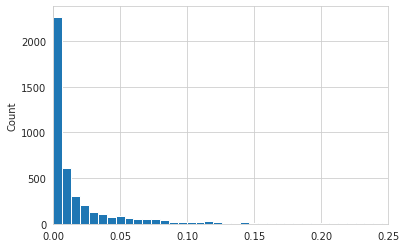

In [45]:
# Plot the distribution of count_j and weight_j
weight_w = []
for res in z.items():
    weight_w.append(res[1])
plt.xlim((0,0.25))
plt.ylabel('Count')
plt.hist(weight_w,bins=500)

In [31]:
top = {'keith': 3.2768988331008737, 'of': 2.3007458370363647, 'the': 2.2670957294474223, 'christian': 2.1488457988109038, 'church': 1.892630794544217, 'faith': 1.8177410561204175, 'it': 1.790967422865447, 'islam': 1.7752040833287275, 'christ': 1.7312057996774541, 'jesus': 1.6460490829231536}

In [38]:
top_word = []
top_value = []
for key in top:
    top_word.append(key)
    top_value.append(top[key])
print(top_word)
print(top_value)

['keith', 'of', 'the', 'christian', 'church', 'faith', 'it', 'islam', 'christ', 'jesus']
[3.2768988331008737, 2.3007458370363647, 2.2670957294474223, 2.1488457988109038, 1.892630794544217, 1.8177410561204175, 1.790967422865447, 1.7752040833287275, 1.7312057996774541, 1.6460490829231536]


<BarContainer object of 10 artists>

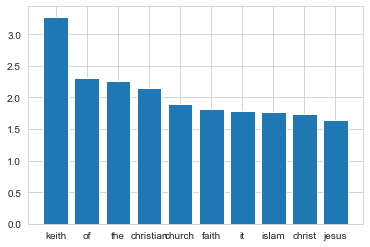

In [52]:
plt.bar(top_word,top_value)

ValueError: could not convert string to float: 'keith'

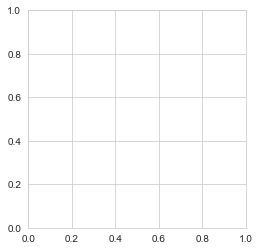

In [53]:
fig1, ax1 = plt.subplots()
patches, texts, autotexts = ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.0f%%',
                                    shadow=False, startangle=170)